In [2]:
SEED = 0
cores = 8

from numpy.random import seed
seed(SEED)
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

from sklearn.model_selection import RepeatedKFold, cross_val_score
from numpy import mean, std
import matplotlib.pyplot as plt
from scipy import stats
from xgboost import plot_importance

In [19]:
df_train=pd.read_csv("~/proj_ua/data/ua_full.v1.csv")
df = df_train[df_train['from']=="cha"]
df2 = df.query('age>=18 & eGFR_ckd<60')

X = df2[["age","male","he_uph", "he_unitr", "he_usg", "he_upro", "he_uglu", "he_uket", "he_ubil", "he_ubld", "he_uro"]]
y = df2["eGFR_ckd"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

/home/danssa/anaconda3/envs/xgb_tpot/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [13]:
#standardization

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
std_cols = X_train.columns[X_train.max() > 1].tolist()
scaled_X_train = X_train.copy()
features = scaled_X_train[std_cols]
features = scaler.fit_transform(features.values)
scaled_X_train[std_cols] = features

In [14]:
def evaluate_model(X, y, model):
    cv = RepeatedKFold(n_splits=5, n_repeats=7, random_state=SEED)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=cores)
    return scores

 # model : tpot ua reg eg60.vq
    
model = XGBRegressor(colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, 
                     max_depth=7, min_child_weight=11, n_estimators=1000, 
                     nthread=6, objective="reg:squarederror", 
                     reg_alpha=0.25, reg_lambda=4, subsample=0.4, random_state=SEED).fit(scaled_X_train, y_train)
scores = evaluate_model(scaled_X_train, y_train, model)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: -9.490 (0.106)


In [15]:
#feature importance

df_imp = pd.DataFrame({'imp':model.feature_importances_}, index = model.get_booster().feature_names)
df_imp = df_imp[df_imp.imp > 0].sort_values('imp').copy()
feat_num = df_imp.shape[0]
print("total number of features =", feat_num)

total number of features = 11


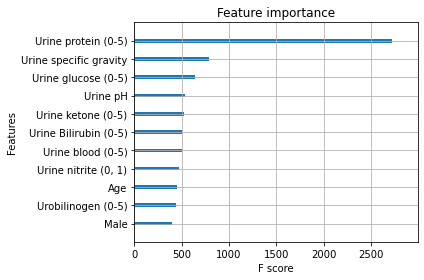

In [16]:
feat_names = model.get_booster().feature_names
df_feat_names = pd.DataFrame(feat_names, index=feat_names)
names = pd.read_csv('/home/danssa/KNHANES_eGFR/knhanes_urine_explain.csv', index_col ='var')
model.get_booster().feature_names = names.loc[df_feat_names.index,'name'].tolist()
g = plot_importance(model.get_booster(),importance_type='gain', show_values=False).get_figure()
plt.tight_layout()
plt.show()
#g.savefig('figtab/xgboost_importance.pdf', dpi=300, bbox_inches='tight')

In [17]:
model.get_booster().feature_names = feat_names #recover model feature names

In [20]:
std_df=X_test[std_cols].copy()
scaled_X_test = X_test.copy()
features = scaled_X_test[std_cols]
features = scaler.transform(features.values)
scaled_X_test[std_cols] = features

In [21]:
y_pred = model.predict(scaled_X_test)

from sklearn.metrics import mean_absolute_error
print('Mean absolute error = %.3f' % mean_absolute_error(y_test, y_pred))

Mean absolute error = 9.443


In [23]:
import statsmodels.api as sm

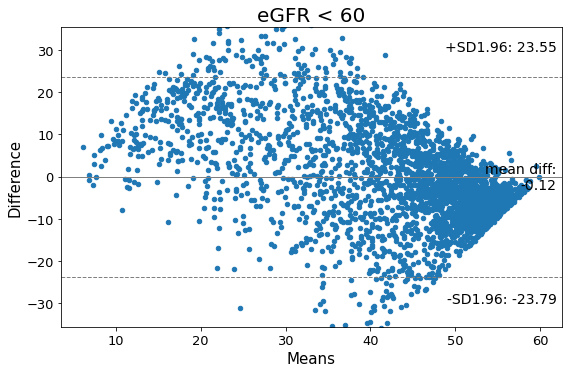

In [41]:
f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(y_pred, y_test, ax = ax)
plt.title("eGFR < 60", fontsize=20)
plt.show()

[2.78926   3.9638257 3.8264036 ... 3.8942513 2.197905  3.967787 ] [16.268974 52.6584   45.89718  ... 49.119267  9.006126 52.86741 ]


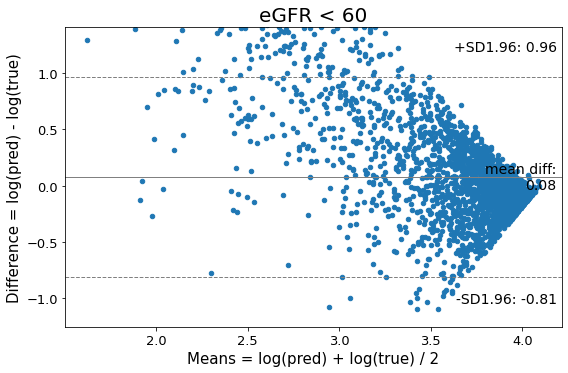

In [40]:
#log transformation bland-althman plot

import math 

y_pred_log = np.log(y_pred)
y_test_log = np.log(y_test)
print(y_pred_log, y_pred)

f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(y_pred_log, y_test_log, ax = ax)
plt.xlabel('Means = log(pred) + log(true) / 2')
plt.ylabel('Difference = log(pred) - log(true)')
plt.title('eGFR < 60', fontsize=20)
plt.show()

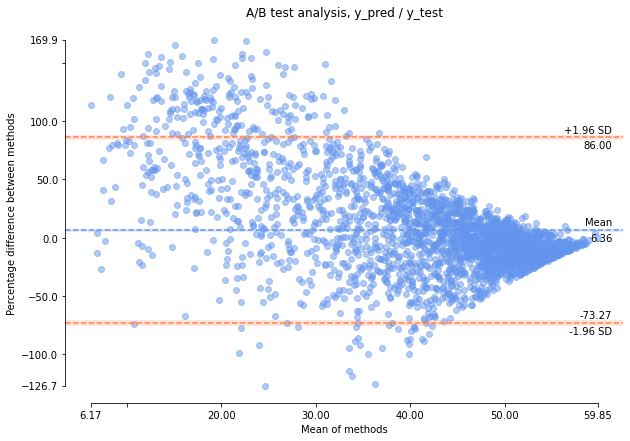

In [27]:
#bland altman A/B method
##https://towardsdatascience.com/why-how-to-use-the-bland-altman-plot-for-a-b-testing-python-code-78712d28c362

import pyCompare

pyCompare.blandAltman(y_pred, y_test, percentage=True, title='A/B test analysis, y_pred / y_test')

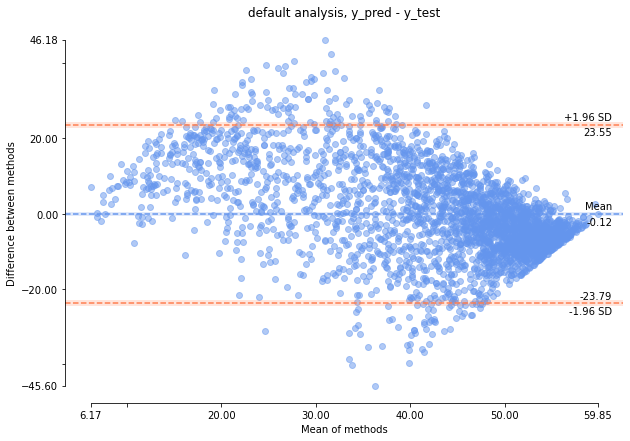

In [28]:
pyCompare.blandAltman(y_pred, y_test, title='default analysis, y_pred - y_test')

In [29]:
#plot in train prediction 

y_train_round = round(y_train)
y_train_pred = model.predict(scaled_X_train)

d_train = {'true_eGFR' : y_train, 'round_eGFR' : y_train_round, 'pred_eGFR' : y_train_pred, 'pred-true' : y_train_pred - y_train, 'ABS pred-true' : abs(y_train_pred-y_train)}
y_train_pd = pd.DataFrame(data=d_train)

y_train_gb = y_train_pd.groupby('round_eGFR').agg(['mean', 'std', 'count'])
y_train_gb.columns = ["_".join(x) for x in y_train_gb.columns.ravel()]
y_train_gb

,true_eGFR_mean,true_eGFR_std,true_eGFR_count,pred_eGFR_mean,pred_eGFR_std,pred_eGFR_count,pred-true_mean,pred-true_std,pred-true_count,ABS pred-true_mean,ABS pred-true_std,ABS pred-true_count
round_eGFR,,,,,,,,,,,,
2.0,2.204578,0.254744,8,21.116264,10.687479,8,18.911687,10.800863,8,18.911687,10.800863,8
3.0,2.997236,0.259047,27,16.821768,8.228282,27,13.824531,8.266908,27,14.052597,7.857443,27
4.0,4.016453,0.291087,63,19.756273,7.238774,63,15.739821,7.263197,63,15.739821,7.263197,63
5.0,4.972451,0.263766,90,21.465010,10.303341,90,16.492558,10.275225,90,16.566418,10.154363,90
6.0,6.006055,0.269820,95,21.425333,7.786861,95,15.419278,7.816553,95,15.537132,7.577027,95
7.0,6.974384,0.251655,121,21.401398,9.627459,121,14.427013,9.642742,121,14.477655,9.565902,121
8.0,7.999052,0.275476,96,24.860903,8.035505,96,16.861851,8.109648,96,16.861851,8.109648,96
9.0,8.992991,0.309995,102,24.736786,8.049461,102,15.743794,8.026858,102,15.758018,7.998621,102
10.0,9.941847,0.286274,86,26.096106,8.780803,86,16.154260,8.763014,86,16.249636,8.582743,86


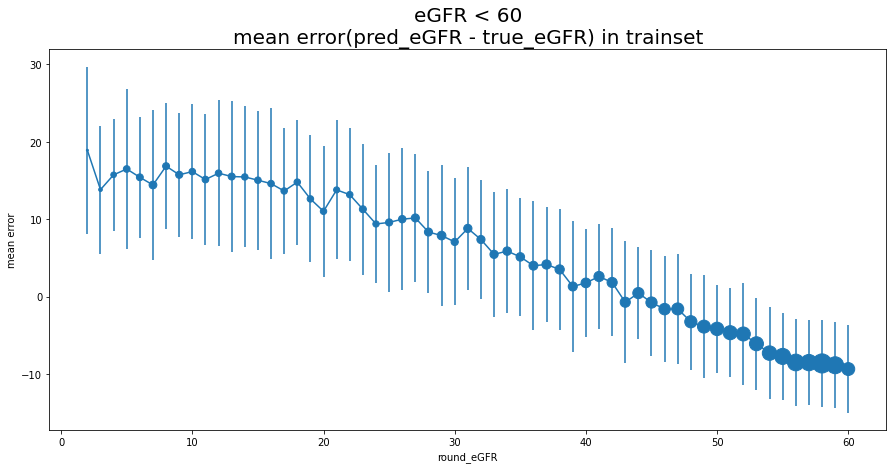

In [33]:
#plot errorbar

plt.rcParams['figure.figsize']=(15,7)
plt.errorbar(x=y_train_gb.index, y=y_train_gb['pred-true_mean'], yerr=y_train_gb['pred-true_std'])
plt.scatter(x=y_train_gb.index, y=y_train_gb['pred-true_mean'], s=y_train_gb['pred-true_count']*0.5)
plt.title('eGFR < 60\nmean error(pred_eGFR - true_eGFR) in trainset', fontsize=20)
plt.xlabel('round_eGFR')
plt.ylabel('mean error')
plt.show()